<a href="https://colab.research.google.com/github/igt14/HousePricesModelling/blob/main/Moringa_Data_Science_Module2_W2_Independent_Project_2021_10_Ian_Gathumbi_Python_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Defining the question

What are some of the factors affecting housing prices?

In [1]:
# Importing the libraries we will usee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# These are the user defined functions that we will use

# This tells us how many row and columns our dataset has
#
def rows_and_columns(df):
  return print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

# A table showing the percentage of missing values per column
#
def percent_missing_values(df):
  # Creating a dataframe showing percentage of missing values
  percentage = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False).to_frame()

  # Renaming the column
  percentage.columns = ['Percentage Missing']

  # Returning a dataframe with the percentage of missing values
  return percentage

# Checking and dropping duplicate values
#
def duplicated_records(df):
  # Checking if there are duplicated values
  if df.duplicated().any() == True:

  # Dropping duplicates if found 
    df.drop_duplicates(inplace=True)
    return('Duplicates dropped')
  
  # Print no duplicates if there are none
  else:
    return print('No duplicated records') 

# Calculating variance inflation factor to detect multicollinearity
def calc_vif(X):
  from statsmodels.stats.outliers_influence import variance_inflation_factor
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  
  return vif 

# 2. Loading the data

In [3]:
# Loading our dataset
house = pd.read_csv('/content/Independent Project Week 7 - house_data.csv')

In [4]:
# Shape of the datasest
rows_and_columns(house)

The dataset has 21613 rows and 20 columns


In [5]:
# Dataset info
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

In [6]:
# Previewing the top of our dataset
house.head(3)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [7]:
# Previewing the bottom of our dataset
house.tail(3)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21610,1523300141,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


# 3. Data preparation

In [8]:
# Dropping irrelevant columns
house.drop(labels=['id', 'lat', 'long'], axis=1, inplace=True)

In [9]:
# Checking for missing values
percent_missing_values(house)

,Percentage Missing
sqft_lot15,0.0
view,0.0
bedrooms,0.0
bathrooms,0.0
sqft_living,0.0
sqft_lot,0.0
floors,0.0
waterfront,0.0
condition,0.0
sqft_living15,0.0


In [10]:
# Checking for duplicates
duplicated_records(house)

'Duplicates dropped'

Using the year built column we can find out how old a house is as this may be a factor in its price. We are assuming these prices are from 2021

In [11]:
# Creating a new column 'age' showing how old the house is
# Assuming these prices are from 2021, the age of the house is 2021 minus the year it was built
house['age'] = 2021 - house['yr_built']

We want to use zip code in our model because location could be a factor in house prices. Let's see how many unique zipcodes we have in our dataset

In [12]:
house['zipcode'].nunique()

70

There are 70 unique zipcodes and since they are categorical we'd have to create 69 new dummy variables which are far too many.

The first 3 digits of a zipcode represent a city/town as the image below shows
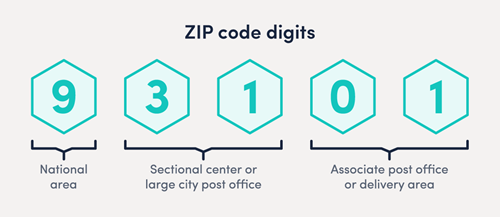

This means that houses with the same first three digits of a zipcode are from a similar area. So we will create a new column with the first three digits of our zipcodes and that will reduce the amount of dummy variables we will have to create.

In [13]:
# First we have to convert the zipcode column type to string to be able to splice the digits 
house['zipcode'] = house['zipcode'].astype(str)
# Create a new column with the first three digits of the zip code
house['zip'] = house['zipcode'].str[0:3]
# Seeing how many unique zip we get
house['zip'].unique()

array(['981', '980'], dtype=object)

In [14]:
# Our dataset has houses from two areas 981 and 980
# We will now create a dummy variable for the zip column
house = pd.get_dummies(house, columns=['zip'], drop_first=True)
house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,age,zip_981
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,1340,5650,66,1
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,1690,7639,70,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,2720,8062,88,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,1360,5000,56,1
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,1800,7503,34,0


# 3. Exploratory data analysis

Before we do EDA let's classify our variables by data type


1. Numerical continuous - price, sqft_living, sqft_lot, sqft_above, sft_basement, sqft_living15, sqft_lot15, age 
2. Numerical discrete - bedrooms, bathrooms, floors, view, condition, grade
3. Categorical nominal - waterfront, zipcode




## 3.1 Univariate

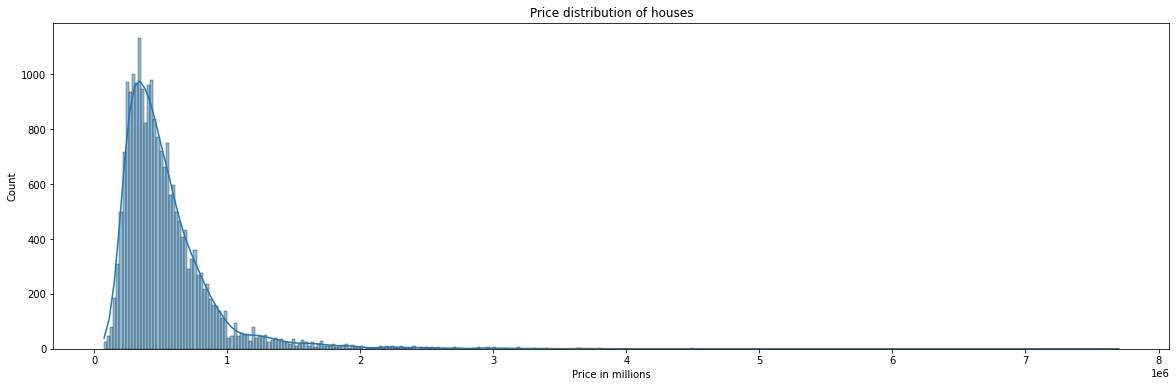

In [16]:
# Creating a histogram showing the distribution of housing prices
plt.figure(figsize=(20,6))
sns.histplot(data=house, x='price', kde=True)
plt.xlabel('Price in millions')
plt.title('Price distribution of houses')
plt.show()

As you can see the distribution of prices is positively skewed, with most houses priced under a million. This is because there are outliers and this is something to consider when modelling later on.

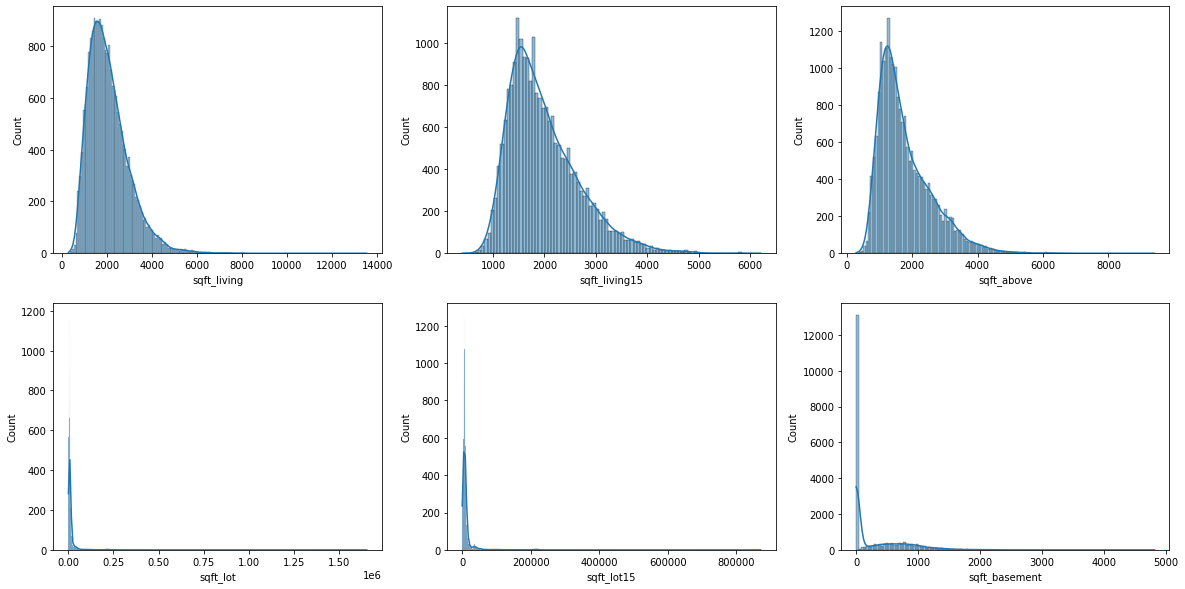

In [15]:
# Histograms to show the distribution of the other continous variables 
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,10))
sns.histplot(data=house, x='sqft_living', kde=True, ax=ax1)
sns.histplot(data=house, x='sqft_lot', kde=True, ax=ax4)
sns.histplot(data=house, x='sqft_above', kde=True, ax=ax3)
sns.histplot(data=house, x='sqft_basement', kde=True, ax=ax6)
sns.histplot(data=house, x='sqft_living15', kde=True, ax=ax2)
sns.histplot(data=house, x='sqft_lot15', kde=True, ax=ax5)
plt.show()

The distribution of square feeet of living area, above, parking layout and basement are positively skewed due to some outliers. Also most of the houses do not have a basement and have small parking layout areas

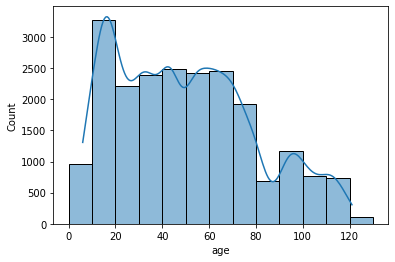

In [17]:
sns.histplot(data=house, x='age', kde=True, bins=[x for x in range(0,140,10)])

Most of the houses are between 10 and 20 years old.

In [19]:
house[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age']].describe()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,age
count,2.160700e+04,21607.000000,2.160700e+04,21607.000000,21607.000000,21607.000000,21607.000000,21607.000000
mean,5.402008e+05,2079.954783,1.511019e+04,1788.397186,291.557597,1986.591799,12770.571991,50.002083
std,3.674061e+05,918.526856,4.142579e+04,828.156250,442.618358,685.436161,27307.553760,29.370686
min,7.500000e+04,290.000000,5.200000e+02,290.000000,0.000000,399.000000,651.000000,6.000000
25%,3.217250e+05,1428.500000,5.040000e+03,1190.000000,0.000000,1490.000000,5100.000000,24.000000
50%,4.500000e+05,1910.000000,7.620000e+03,1560.000000,0.000000,1840.000000,7620.000000,46.000000
75%,6.450000e+05,2550.000000,1.069200e+04,2210.000000,560.000000,2360.000000,10083.500000,70.000000
max,7.700000e+06,13540.000000,1.651359e+06,9410.000000,4820.000000,6210.000000,871200.000000,121.000000


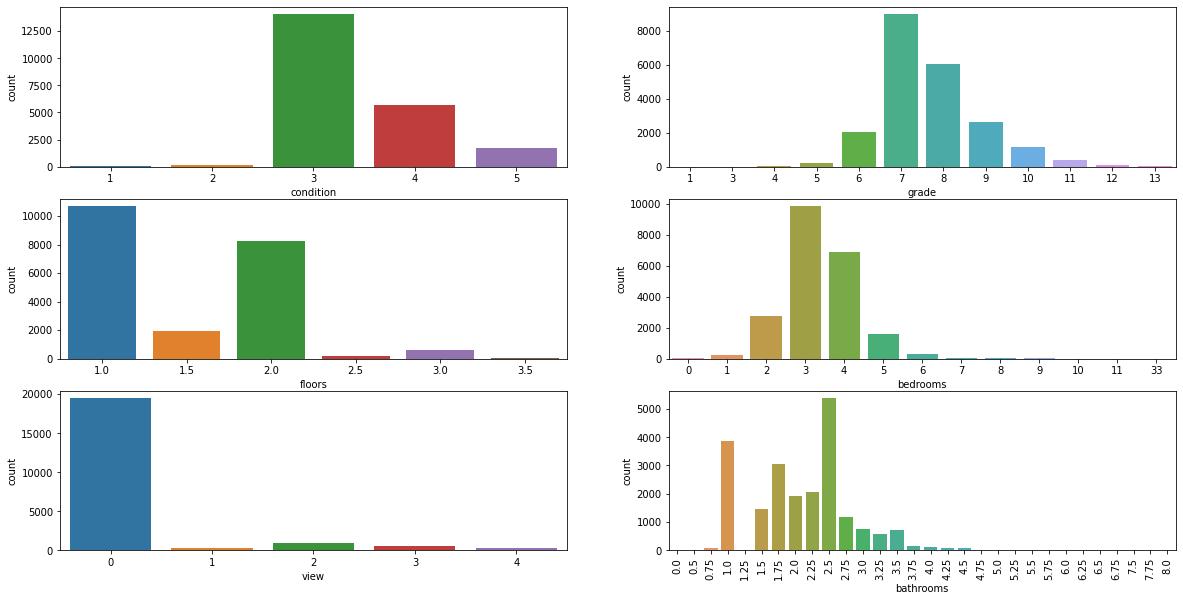

In [21]:
# Plotting the frequency of the other discrete variables
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize=(20,10))
sns.countplot(x=house['bedrooms'], ax=ax4)
sns.countplot(x=house['floors'], ax=ax3)
sns.countplot(x=house['view'], ax=ax5)
sns.countplot(x=house['bathrooms'], ax=ax6)
sns.countplot(x=house['condition'], ax=ax1)
sns.countplot(x=house['grade'], ax=ax2)
plt.xticks(rotation=90)
plt.show()

In [19]:
house['zip_981'].value_counts()

0    12633
1     8974
Name: zip_981, dtype: int64

Majority of our houses are in zipcode 980

In [20]:
house['waterfront'].value_counts()

0    21444
1      163
Name: waterfront, dtype: int64

A strong majority of households don't have a waterfront

## 3.2 Bivariate

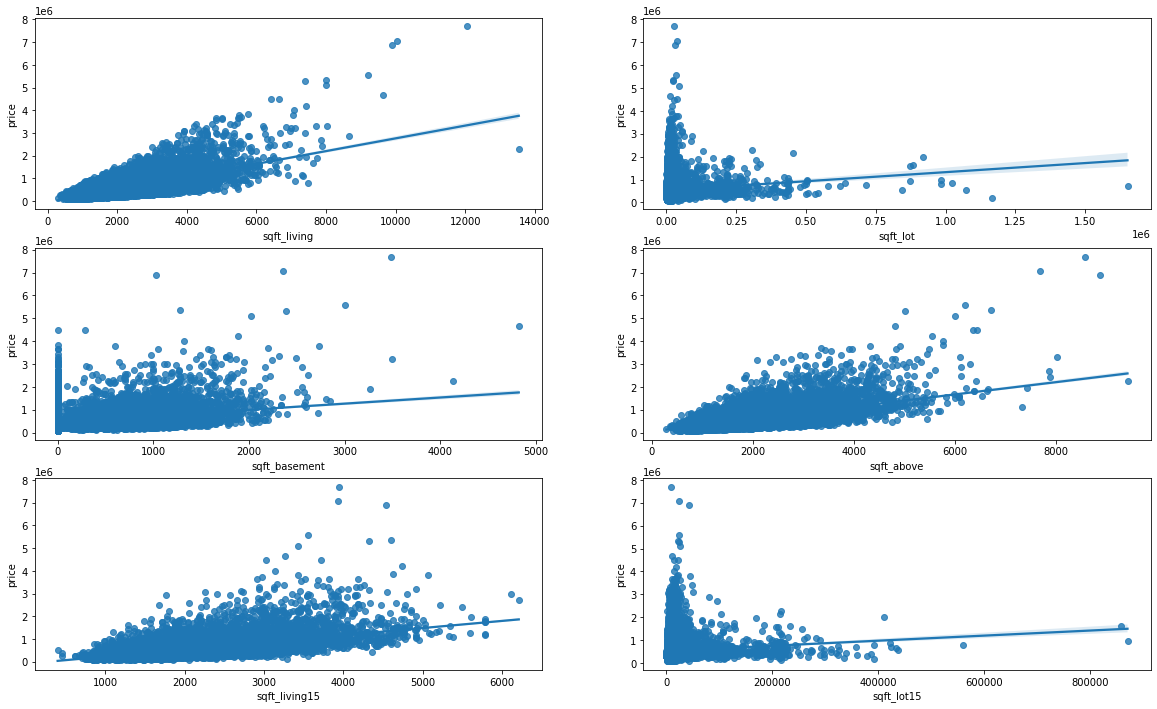

In [23]:
# Scatter plot for price vs the continuous variables
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,12))
sns.regplot(x=house['sqft_living'], y=house['price'], ax=ax1)
sns.regplot(x=house['sqft_lot'], y=house['price'], ax=ax2)
sns.regplot(x=house['sqft_basement'], y=house['price'], ax=ax3)
sns.regplot(x=house['sqft_above'], y=house['price'], ax=ax4)
sns.regplot(x=house['sqft_living15'], y=house['price'], ax=ax5)
sns.regplot(x=house['sqft_lot15'], y=house['price'], ax=ax6)
plt.show()

House prices are positively related with the square feet of the living area, parking layout, above and basement. Meaning the larger the square feet the more expensive a house is. When we model later on, we expect that the coeficients of the variables above will be positive.

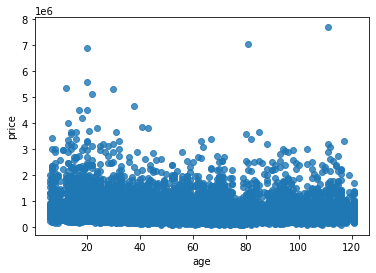

In [24]:
sns.regplot(x=house['age'], y=house['price'])
plt.show()

There seems to be no clear relationship between the age of a house and its price.  

## 4. Collinearity


In [21]:
# We will use vif to detect multicollinearity which does not apply to categorical variables
# Creating a list of numerical varibles
columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade',
           'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age']
calc_vif(house[columns])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,price,7.611659
1,bedrooms,22.480850
2,bathrooms,28.095994
3,sqft_living,inf
4,sqft_lot,2.364710
5,floors,16.041200
6,view,1.373227
7,condition,28.132313
8,grade,70.322744
9,sqft_above,inf


Some of a variables like bedrooms, bathrooms, floors, condition, grade, sqft_living are multicollinear. This means that ordinary linear regression may not be the most reliable regression model to use.

# 5. Train Test split

In [22]:
# Separating our dependent and independent variables
X = house.drop(labels=['price', 'yr_built', 'yr_renovated', 'zipcode'], axis=1)
y = house['price']

# Splitting our dataset into a training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# 6. Modelling

## 6.1 Multiple linear regression

In [23]:
from sklearn.linear_model import LinearRegression

# Performing ordinary linear regression
linear = LinearRegression(normalize=True)
linear.fit(X_train, y_train)

# Creating a dictionary of the coefficients with their variables as the key
linear_coef = {}
for feat, coef in zip(X.columns, linear.coef_):
  linear_coef[feat] = coef

linear_coef

{'age': 3015.196010677507,
 'bathrooms': 45096.79058795658,
 'bedrooms': -37795.18838965297,
 'condition': 24141.418993493997,
 'floors': 6880.425122361006,
 'grade': 113695.13623433957,
 'sqft_above': 86.35928998718653,
 'sqft_basement': 71.58985111093709,
 'sqft_living': 86.58398138757258,
 'sqft_living15': 38.356458590489005,
 'sqft_lot': 0.10555885198217807,
 'sqft_lot15': -0.5351897037511414,
 'view': 38961.82630501307,
 'waterfront': 602649.2551225678,
 'zip_981': 68647.78627910675}

In [24]:
# Finding the average performance of the linear model using cross validation
from sklearn.model_selection import cross_validate
linear_cv = cross_validate(linear, X, y, cv = 10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
linear_test = abs(linear_cv['test_score'].mean())
linear_train = abs(linear_cv['train_score'].mean())
print(f'Average performance on training is a root mean squared error score of {linear_train}')
print(f'Average performance on testing is a root mean squared error score of {linear_test}')

Average performance on training is a root mean squared error score of 214563.30704074595
Average performance on testing is a root mean squared error score of 215530.84935664176


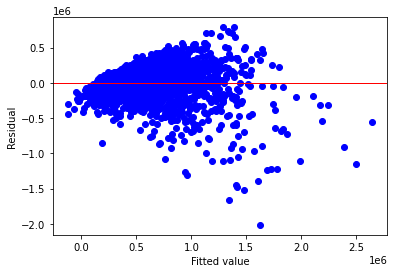

In [25]:
# Plotting the residuals
# Calculating the residuals
residuals = np.subtract(linear.predict(X_test),y_test)

# Plotting the residuals
plt.scatter(linear.predict(X_test), residuals, color='blue')
plt.ylabel('Residual')
plt.xlabel('Fitted value')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

The residuals are not randomly spaced out and are cone shaped suggesting that there is heteroscedasticity

In [26]:
# Confirming heteroscedasticity using bartlett's test
import scipy as sp

test_result, p_value = sp.stats.bartlett(linear.predict(X_test), residuals)

if p_value < 0.05:
  print('Reject null hypothesis therefore variances are heteroscedastic')
else:
  print('Do not reject null hypothesis therefore variances are homoscedastic')

Reject null hypothesis therefore variances are heteroscedastic


The OLS model above is not reliable due to the presence of outliers, multicollinearity and heteroscedasticity

## 6.2 Quantile Regression

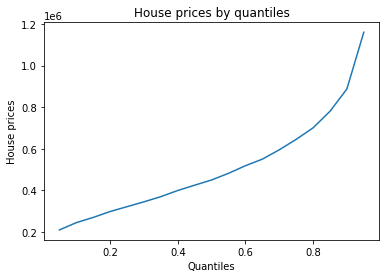

In [27]:
# Plotting the house prices by quantiles
price_quan = house['price'].quantile(np.arange(0.05,1,0.05).tolist())
plt.plot(price_quan.index, price_quan.values)
plt.xlabel('Quantiles')
plt.ylabel('House prices')
plt.title('House prices by quantiles')
plt.show()

As you can see above house prices are steadily increasing per quantile suggesting that the factors determining prices have different magnitudes per quantile. Quantile regression will help us determine the coefficients of our factors in a particular quantile and we can see if they are signifiantly different to other quntiles.

In [40]:
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
var = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age', 'zip_981']

quantiles = np.arange(0.1,1,0.1) 
models = []
params = []

form = 'price ~ bedrooms + bathrooms + sqft_lot + floors + view + C(waterfront) + condition + grade + sqft_above + sqft_basement + sqft_living15 + sqft_lot15 + age + C(zip_981)'
quan = smf.quantreg(formula=form, data=house[var])

for qt in quantiles: 
	res = quan.fit(q=qt)
	models.append(res)
	params.append([qt] + res.params.values.tolist())

params = pd.DataFrame(data = params, columns =['quantile'] + X.columns.tolist())
params

,quantile,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,age,zip_981
0,0.1,-429578.787497,162960.968872,54347.733735,-16169.978210,21831.647154,0.091761,34386.249876,17032.525314,17956.253870,48980.388465,60.183724,79.303101,41.759853,0.112040,882.126954
1,0.2,-728312.801112,195043.047658,63500.553056,-22350.520568,27202.960788,0.125192,36923.970927,20227.521483,22202.232166,81088.075008,65.056556,78.605353,63.995103,-0.054830,1826.391306
2,0.3,-841192.623298,312370.858818,65016.263657,-21776.750515,27636.858698,0.137095,40033.781842,23804.760466,24516.241236,93520.300239,72.037184,84.824644,69.355087,-0.185054,2213.635730
3,0.4,-863288.281758,210251.515231,63346.274876,-24494.229570,28519.580989,0.199287,41108.758335,29853.587888,23948.463039,98188.331751,83.685624,99.812175,68.198615,-0.251077,2358.567761
4,0.5,-889483.344824,394248.688778,60289.539894,-24361.502602,31624.248533,0.138540,38634.006306,35517.835014,24956.085670,103785.328493,95.210544,109.778191,59.297890,-0.184683,2537.022341
5,0.6,-890229.714463,572532.256368,58300.349987,-24311.147747,31056.002447,0.154482,34075.606413,41020.481662,23697.351137,107363.461562,105.375249,124.144878,57.605697,-0.263701,2629.839199
6,0.7,-887051.830329,392259.743057,60735.941958,-26533.046704,27735.886085,0.169394,21923.981070,60515.747239,29329.534760,110325.081644,130.271758,142.426826,48.635948,-0.355868,2556.680550
7,0.8,-907560.470762,179191.933663,59710.822780,-34415.379456,33403.928061,0.302681,21815.570952,67893.288085,20173.221476,116267.145214,157.927545,164.923573,49.436048,-0.669492,2978.973272
8,0.9,-820715.926674,-27877.275126,-10562.059492,-63898.931485,73289.489021,0.035244,44317.247613,315322.721233,7386.156334,101836.800276,304.358612,228.787219,-58.469046,-0.684829,4854.710554


Some observations: 
1. bathrooms, sqft_living and sqft_lot are negavitely realted to house price for the top priced prices q=0.9
2. the coefficients for most variables increase as you go up the quantiles





## 6.3 Ridge Regression

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Hyper-parameter tuning to find the alpha level that will result in the best model score
ridge = Ridge(normalize=True)
search = GridSearchCV(estimator=ridge, param_grid={'alpha':np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}, 
                      scoring= 'neg_root_mean_squared_error', n_jobs=1, cv=10)
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_) 

{'alpha': 0.1}
-219427.5732652347


The best alpha value according to our training dataset is 0.1 and we will use that to test the performance of the ridge model on the test dataset

In [42]:
# Applying the tuned alpha value of our datasets to train our model
ridge1 = Ridge(normalize=True, alpha=0.1)
ridge1.fit(X_train, y_train)

# Creating a dictionary of the variable coefficients
ridge_coef = {}
for coef, var in zip(ridge1.coef_, X.columns):
  ridge_coef[var] = coef

ridge_coef

{'age': 2450.836512441448,
 'bathrooms': 42512.54553562971,
 'bedrooms': -27726.93051481089,
 'condition': 25559.359798037243,
 'floors': 11438.30344415438,
 'grade': 94946.05645198408,
 'sqft_above': 80.54443429033597,
 'sqft_basement': 71.09924166237923,
 'sqft_living': 81.7375881683337,
 'sqft_living15': 52.97340934211839,
 'sqft_lot': 0.07952200739317111,
 'sqft_lot15': -0.4078607107834185,
 'view': 43115.7221615037,
 'waterfront': 557984.4981312044,
 'zip_981': 71923.79276186098}

In [43]:
# Finding the average performance of the ridge model using cross validation
ridge_cv = cross_validate(ridge1, X, y, cv = 10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
ridge_test = abs(ridge_cv['test_score'].mean())
ridge_train = abs(ridge_cv['train_score'].mean())
print(f'Average performance on training is a root mean squared error score of {ridge_train}')
print(f'Average performance on testing is a root mean squared error score of {ridge_test}')

Average performance on training is a root mean squared error score of 215551.11719676014
Average performance on testing is a root mean squared error score of 216154.20379612307


## 6.4 Lasso Regression

In [44]:
from sklearn.linear_model import Lasso

# Hyper-parameter tuning to find the alpha level that will result in the best model score
lasso = Lasso(normalize=True)
search = GridSearchCV(estimator=lasso, param_grid={'alpha':np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}, 
                      scoring= 'neg_root_mean_squared_error', n_jobs=1, cv=10)

search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_) 

{'alpha': 0.6}
-218578.82285876106


The best alpha value according to our training dataset is 0.6 and we will use that to test the performance of the lasso model on the test dataset

In [45]:
# Applying the tuned alpha value of our datasets to train our model
lasso1 = Lasso(normalize=True, alpha=0.6)
lasso1.fit(X_train, y_train)

# Creating a dictionary of the variable coefficients
lasso_coef = {}
for coef, var in zip(lasso1.coef_, X.columns):
  lasso_coef[var] = coef

lasso_coef

{'age': 3009.9776493162144,
 'bathrooms': 44891.79375247438,
 'bedrooms': -37576.01091491517,
 'condition': 24003.642990524673,
 'floors': 6740.67852015794,
 'grade': 113708.1787673001,
 'sqft_above': 14.674059325426258,
 'sqft_basement': 0.0,
 'sqft_living': 158.18577259186964,
 'sqft_living15': 38.209492139114154,
 'sqft_lot': 0.09851668251530774,
 'sqft_lot15': -0.5241287724952391,
 'view': 38975.6256628494,
 'waterfront': 602053.2502266773,
 'zip_981': 68528.04266623638}

In [46]:
# Finding the average performance of the lasso model using cross validation
lasso_cv = cross_validate(lasso1, X, y, cv = 10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
lasso_test = abs(lasso_cv['test_score'].mean())
lasso_train = abs(lasso_cv['train_score'].mean())
print(f'Average performance on training is a root mean squared error score of {lasso_train}')
print(f'Average performance on testing is a root mean squared error score of {lasso_test}')

Average performance on training is a root mean squared error score of 214563.50056521632
Average performance on testing is a root mean squared error score of 215527.67255987428


## 6.5 Net Elastic Regression

In [47]:
from sklearn.linear_model import ElasticNet

# Hyper-parameter tuning to find the alpha level and l1 ratio that will result in the best model score
elastic = ElasticNet(normalize=True)
search = GridSearchCV(estimator=elastic, param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]}, scoring='neg_root_mean_squared_error',
                    n_jobs=1, refit=True, cv=10)

search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_) 

{'alpha': 1e-05, 'l1_ratio': 0.8}
-218653.60153146592


The best alpha value and l1 ratio according to our training dataset is 1e-05 and 0.8 respectively. We will use them to test the performance of the net elastic model on the test dataset

In [48]:
# Applying the tuned alpha and l1 ration to train our model
elastic1 = ElasticNet(normalize=True, alpha=1e-05, l1_ratio=0.8)
elastic1.fit(X_train, y_train)

# Creating a dictionary of the variable coefficients
elastic_coef = {}
for coef, var in zip(elastic1.coef_, X.columns):
  elastic_coef[var] = coef

elastic_coef

{'age': 2784.7167150344017,
 'bathrooms': 43908.826497704904,
 'bedrooms': -33923.752131726265,
 'condition': 24957.00705498976,
 'floors': 8715.6149514754,
 'grade': 105839.84698963279,
 'sqft_above': 84.2911770835465,
 'sqft_basement': 71.46516693247202,
 'sqft_living': 84.87164422356312,
 'sqft_living15': 45.095888864621664,
 'sqft_lot': 0.09457911552919153,
 'sqft_lot15': -0.48493944018386953,
 'view': 40663.46616324395,
 'waterfront': 586096.996246874,
 'zip_981': 70893.75686775448}

In [49]:
# Finding the average performance of the net elastic model using cross validation
elastic_cv = cross_validate(elastic1, X, y, cv = 10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
elastic_test = abs(elastic_cv['test_score'].mean())
elastic_train = abs(elastic_cv['train_score'].mean())
print(f'Average performance on training is a root mean squared error score of {elastic_train}')
print(f'Average performance on testing is a root mean squared error score of {elastic_test}')

Average performance on training is a root mean squared error score of 214755.83573564063
Average performance on testing is a root mean squared error score of 215560.7530828909


# 7 Comparing the models

In [50]:
# Creating a dataframe showing the root mean squared errors of each model on training and testing
scores = {
    'model' : ['linear', 'ridge', 'lasso', 'net elatic'],
    'test score' : [linear_test, ridge_test, lasso_test, elastic_test],
    'train score' : [linear_train, ridge_train, lasso_train, elastic_train]
}
scores_df = pd.DataFrame(scores)
scores_df

,model,test score,train score
0,linear,215530.849357,214563.307041
1,ridge,216154.203796,215551.117197
2,lasso,215527.672560,214563.500565
3,net elatic,215560.753083,214755.835736


In [51]:
print('The model that performed best on the training dataset is', scores_df.iloc[scores_df['train score'].idxmin()]['model'])
print('The model that performed best on the testing dataset is', scores_df.iloc[scores_df['test score'].idxmin()]['model'])
print('The model that performed worst on the training dataset is', scores_df.iloc[scores_df['train score'].idxmax()]['model'])
print('The model that performed worst on the testing dataset is', scores_df.iloc[scores_df['test score'].idxmax()]['model'])

The model that performed best on the training dataset is linear
The model that performed best on the testing dataset is lasso
The model that performed worst on the training dataset is ridge
The model that performed worst on the testing dataset is ridge


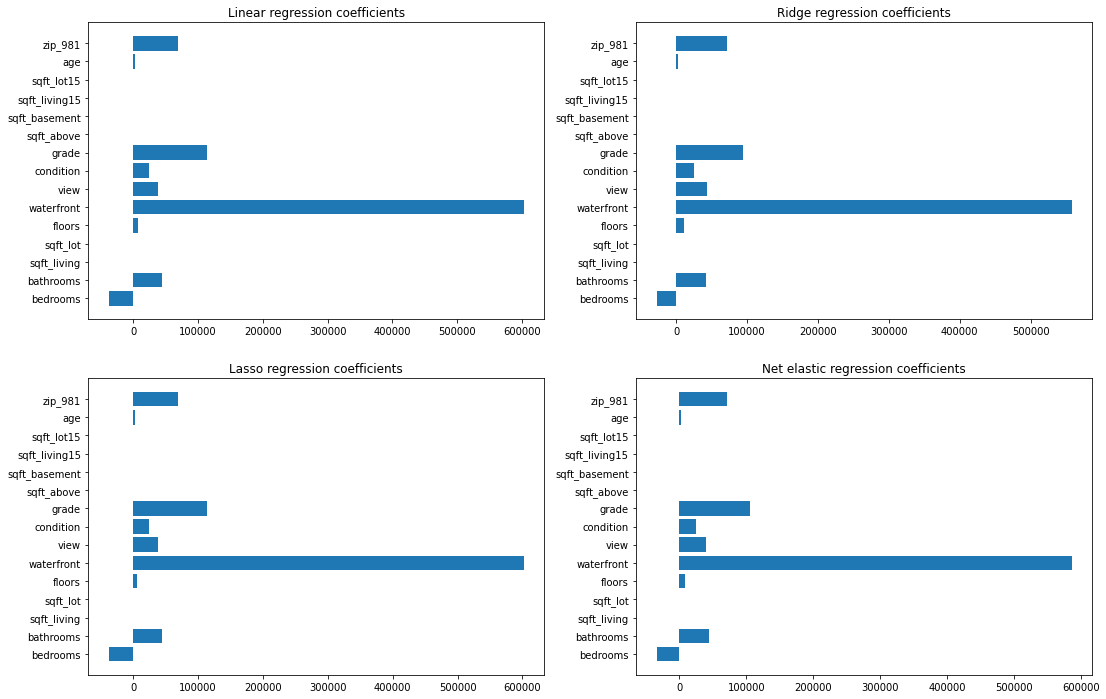

In [52]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(18,12))
ax1.barh(list(linear_coef.keys()), list(linear_coef.values()))
ax1.set_title('Linear regression coefficients')
ax2.barh(list(ridge_coef.keys()), list(ridge_coef.values()))
ax2.set_title('Ridge regression coefficients')
ax3.barh(list(lasso_coef.keys()), list(lasso_coef.values()))
ax3.set_title('Lasso regression coefficients')
ax4.barh(list(elastic_coef.keys()), list(elastic_coef.values()))
ax4.set_title('Net elastic regression coefficients')
plt.show()

Some observations:
1. Whether or not a house has a waterfront was the biggest factor in determining the price of a house. Houses with waterfronts are 600000 more expensive than houses without them holding all other variables constant.
2. Prices and number of bedrooms have a negative relationship
3. Lasso regression reduced the coefficient of sqft_basement to zero meaning ots not a significant factor in housing prices
4. Houses in zip 981 are generally more expensive than those in 980
5. Factors like sqft_living, sqft_lot, sqft_above, sqft_living15, sqft_lot15 have a very small effect on prices compared to others

One way we could improve the model is if we found a way to incorporate the year a house was renovated into our model as it could be a factor